# Stock Options

## Configuration

In [2]:
import glob
import warnings
import pandas as pd
import numpy as np
from scipy.stats import norm
import statistics
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from typing import List, Callable
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from google.colab import drive

##### Configutation #####
drive.mount("/content/drive/")
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set_palette("mako")

##### Defaults #####
DATA_FOLDER_PATH = "drive/MyDrive/UFC/TCC/stock-options/data/"
DATA_PATH = DATA_FOLDER_PATH + "COTAHIST_A*.TXT"
DIVIDENDS_DATA_PATH = DATA_FOLDER_PATH + "petr4_dividends.csv"
TICKER_PATTERN = "".join([f"({ticker})|" for ticker in [
    "PETR",
    "VALE",
    "BOV",
    "ITUB", # ITUB4, Itaú
    "BBAS", # BBAS3, Banco do Brasil
    "ABEV", # ABEV3, Ambev
    "B3SA", # B3SA3, B3
    "BBDC", # BBDC4, Bradesco
]])[:-1]
# Market types for the column 'tipo_mercado'
STOCK_COD, CALL_COD, PUT_COD = 10, 70, 80
FIELD_WIDTHS = [
    2, 8, 2, 12, 3, 12, 10, 3, 4, 13, 13, 13, 13,
    13, 13, 13, 5, 18, 18, 13, 1, 8, 7, 13, 12, 3
]
COLUMNS = [
    "tipo_registro", "data_pregao", "cod_bdi", "cod_negociacao", "tipo_mercado",
    "nome_empresa", "especificacao_papel", "prazo_dias_merc_termo", "moeda_referencia",
    "preco_abertura", "preco_maximo", "preco_minimo", "preco_medio", "preco_ultimo_negocio",
    "preco_melhor_oferta_compra", "preco_melhor_oferta_venda", "numero_negocios",
    "quantidade_papeis_negociados", "volume_total_negociado", "preco_exercicio",
    "ìndicador_correcao_precos", "data_vencimento" , "fator_cotacao",
    "preco_exercicio_pontos", "codigo_isin", "num_distribuicao_papel"
]
USEFUL_COLUMNS = [
    "data_pregao",
    "cod_negociacao", # E.g. PETR4, VALE3
    "tipo_mercado",
    "preco_abertura",
    "preco_ultimo_negocio",
    "volume_total_negociado",
    "preco_exercicio",
    "data_vencimento" ,
]
USEFUL_NUMERICAL_COLUMNS = [
    "preco_abertura",
    "preco_ultimo_negocio",
    "volume_total_negociado",
    "preco_exercicio",
]
USEFUL_DATE_COLUMNS = ["data_pregao", "data_vencimento"]

Mounted at /content/drive/


## Prepare the Data
In this section, we'll prepare the data provided by B3 for stocks, calls and puts taking into account the impact of dividends. Then, we'll register the data so we don't have to go through this process again.

### Load Raw Data

Read files that hold the name pattern: 'DATA_PATH'  
The files are supposed to be formatted as described in ./data/SeriesHistoricas_Layout.pdf

In [ ]:
# %%script false --no-raise-error

class B3FilesFoundNotFound(Exception):
    pass

files: List[str] = glob.glob(DATA_PATH)
if len(files) == 0: raise B3FilesFoundNotFound()

assets_df = pd.DataFrame()
for f in files:
    temp_df = pd.read_fwf(
        f,
        widths=FIELD_WIDTHS,
        names=COLUMNS,
        dtype={"data_pregao": np.int64, "data_vencimento": np.int64},
        header=None,
        # The first and the last rows contain metadata, so we drop them
        skiprows=1,
        skipfooter=1,
    )[COLUMNS]
    temp_df = temp_df[
        (temp_df["cod_negociacao"].str.match(TICKER_PATTERN))
        & (temp_df["tipo_mercado"].isin([STOCK_COD, CALL_COD, PUT_COD]))
    ]
    
    assets_df = assets_df.append(temp_df)

assets_df.reset_index(drop=True, inplace=True)
# Divide all numerical columns by 100 to get the right decimal value
assets_df[USEFUL_NUMERICAL_COLUMNS] = assets_df[USEFUL_NUMERICAL_COLUMNS].div(100)

del temp_df

# Save data
assets_df.to_csv(DATA_FOLDER_PATH + "assets.csv", index=False)

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,nome_empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
0,1,20180102,2,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,21.33,...,33607,12717900,274813428.0,0.00,0,99991231,1,0,BRABEVACNOR1,118
1,1,20180102,78,ABEVA21,70,ABEV FM/EJ,ON,0.0,R$,0.89,...,11,67500,67588.0,20.66,0,20180115,1,0,BRABEVACNOR1,116
2,1,20180102,78,ABEVA22,70,ABEV /EJ,ON,0.0,R$,0.04,...,2,5500,240.0,22.16,0,20180115,1,0,BRABEVACNOR1,117
3,1,20180102,78,ABEVA51,70,ABEV FM/EJ,ON,0.0,R$,0.13,...,78,209200,43157.0,21.66,0,20180115,1,0,BRABEVACNOR1,117
4,1,20180102,78,ABEVA52,70,ABEV FM/EJ,ON,0.0,R$,0.02,...,2,6000,120.0,22.66,0,20180115,1,0,BRABEVACNOR1,117


In [ ]:
assets_df = pd.read_csv(DATA_FOLDER_PATH + "assets.csv")

assets_df.sample(3)

,data_pregao,cod_negociacao,tipo_mercado,preco_abertura,preco_ultimo_negocio,volume_total_negociado,preco_exercicio,data_vencimento
168442,20190530,PETRR290,80,2.36,2.82,979113.0,28.90,20190617
407290,20201002,PETRW252,80,5.08,5.37,57610.0,24.45,20201116
469655,20210531,BOVAG138,70,0.06,0.08,52.0,138.00,20210716


### Datasets

Here, we'll create datasets to analyse the stocks and options for two companies which are Petrobrás and Vale

#### Stocks

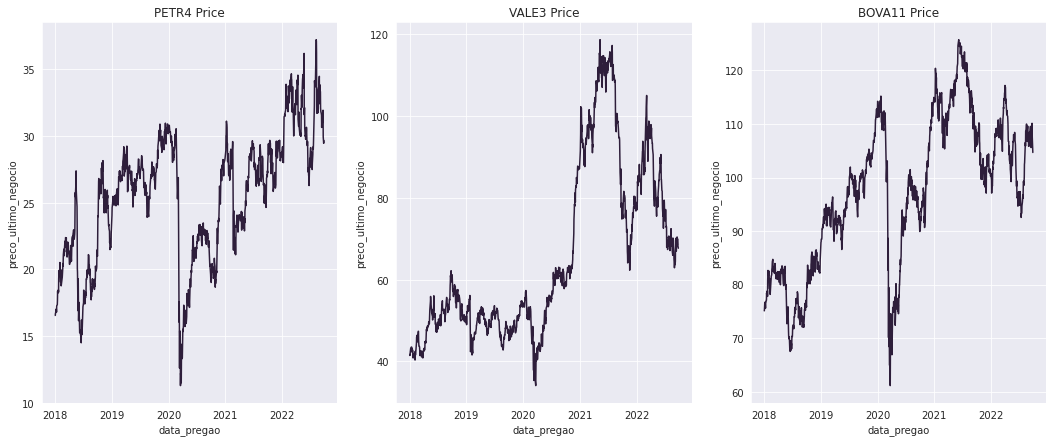

In [ ]:
petr4_stock_df_ = assets_df[
    (assets_df["cod_negociacao"] == "PETR4")
    & (assets_df["tipo_mercado"] == STOCK_COD)
].sort_values("data_pregao").reset_index(drop=True)
petr4_stock_df_["data_pregao"] = pd.to_datetime(petr4_stock_df_["data_pregao"], format="%Y%m%d")

vale3_stock_df_ = assets_df[
    (assets_df["cod_negociacao"] == "VALE3")
    & (assets_df["tipo_mercado"] == STOCK_COD)
].sort_values("data_pregao").reset_index(drop=True)
vale3_stock_df_["data_pregao"] = pd.to_datetime(vale3_stock_df_["data_pregao"], format="%Y%m%d")

itub4_stock_df_ = assets_df[
    (assets_df["cod_negociacao"] == "ITUB4")
    & (assets_df["tipo_mercado"] == STOCK_COD)
].sort_values("data_pregao").reset_index(drop=True)
vale3_stock_df_["data_pregao"] = pd.to_datetime(vale3_stock_df_["data_pregao"], format="%Y%m%d")

bova11_stock_df = assets_df[
    (assets_df["cod_negociacao"] == "BOVA11")
    & (assets_df["tipo_mercado"] == STOCK_COD)
].sort_values("data_pregao").reset_index(drop=True)
bova11_stock_df["data_pregao"] = pd.to_datetime(bova11_stock_df["data_pregao"], format="%Y%m%d")

### Plot Graphs ###
plt.figure(figsize=(18,7))

plt.subplot(1,3,1)
sns.lineplot(data=petr4_stock_df_, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("PETR4 Price")

plt.subplot(1,3,2)
sns.lineplot(data=vale3_stock_df_, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("VALE3 Price")

plt.subplot(1,3,3)
sns.lineplot(data=bova11_stock_df, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("BOVA11 Price")

#### Calls

In [ ]:
petr4_call_df_ = assets_df[
    (assets_df["cod_negociacao"].str.startswith("PETR"))
    & (assets_df["tipo_mercado"] == CALL_COD)
    & (assets_df["especificacao_papel"].str.startswith("PN"))
].sort_values("data_pregao").reset_index(drop=True)
for date_col in USEFUL_DATE_COLUMNS:
    petr4_call_df_[date_col] = pd.to_datetime(petr4_call_df_[date_col], format="%Y%m%d")

vale3_call_df_ = assets_df[
    (assets_df["cod_negociacao"].str.startswith("VALE"))
    & (assets_df["tipo_mercado"] == CALL_COD)
    & (assets_df["especificacao_papel"].str.startswith("ON"))
].sort_values("data_pregao").reset_index(drop=True)
for date_col in USEFUL_DATE_COLUMNS:
    vale3_call_df_[date_col] = pd.to_datetime(vale3_call_df_[date_col], format="%Y%m%d")

itub4_call_df_ = assets_df[
    (assets_df["cod_negociacao"].str.startswith("ITUB"))
    & (assets_df["tipo_mercado"] == CALL_COD)
    & (assets_df["especificacao_papel"].str.startswith("PN"))
].sort_values("data_pregao").reset_index(drop=True)
for date_col in USEFUL_DATE_COLUMNS:
    vale3_call_df_[date_col] = pd.to_datetime(vale3_call_df_[date_col], format="%Y%m%d")

bova11_call_df = assets_df[
    (assets_df["cod_negociacao"].str.startswith("BOVA"))
    & (assets_df["tipo_mercado"] == CALL_COD)
].sort_values("data_pregao").reset_index(drop=True)
for date_col in USEFUL_DATE_COLUMNS:
    bova11_call_df[date_col] = pd.to_datetime(bova11_call_df[date_col], format="%Y%m%d")

display(petr4_call_df_.head(3))
display(vale3_call_df_.head(3))
bova11_call_df.head(3)

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,nome_empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
0,1,2018-01-02,78,PETRA10,70,PETR,PN,0.0,R$,6.53,...,1,1000,6530.0,10.0,0,2018-01-15,1,0,BRPETRACNPR6,186
1,1,2018-01-02,78,PETRC21,70,PETR,PN,0.0,R$,0.07,...,4,1100,94.0,21.0,0,2018-03-19,1,0,BRPETRACNPR6,186
2,1,2018-01-02,78,PETRC20,70,PETR,PN,0.0,R$,0.10,...,5,800,99.0,20.0,0,2018-03-19,1,0,BRPETRACNPR6,186


,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,nome_empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
0,1,2018-01-02,78,VALEA1,70,VALE /EJ,ON NM,0.0,R$,4.72,...,18,8500,41583.0,36.47,0,2018-01-15,1,0,BRVALEACNOR0,194
1,1,2018-01-02,78,VALEB421,70,VALEE /EJ,ON NM,0.0,R$,1.29,...,21,47500,71982.0,41.74,0,2018-02-19,1,0,BRVALEACNOR0,194
2,1,2018-01-02,78,VALEB418,70,VALE /EJ,ON NM,0.0,R$,1.28,...,41,90900,174221.0,41.49,0,2018-02-19,1,0,BRVALEACNOR0,194


,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,nome_empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,...,numero_negocios,quantidade_papeis_negociados,volume_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel
0,1,2018-01-02,78,BOVAA69,70,BOVA,CI,0.0,R$,5.98,...,3,6000,37354.0,69.0,0,2018-01-15,1,0,BRBOVACTF003,103
1,1,2018-01-02,78,BOVAB76,70,BOVA FM,CI,0.0,R$,1.57,...,13,23000,43397.0,76.0,0,2018-02-19,1,0,BRBOVACTF003,103
2,1,2018-01-02,78,BOVAB75,70,BOVA FM,CI,0.0,R$,2.01,...,7,9730,21491.8,75.0,0,2018-02-19,1,0,BRBOVACTF003,103


### Dividends

We need to verify how the payment of dividends impacts the data provided by B3.
Since some stocks doesn't pay dividends to theirs inverstor (e.g. BOVA11), we don't need to worry about them at this point.

In [ ]:
def plot_dividend_diff(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    call_code: str,
    start_date: datetime,
    ex_dividend_date: datetime,
) -> None:
    # Make the time interval symmetic around the dividend payment date
    end_date = ex_dividend_date + (ex_dividend_date - start_date)

    stock_filtered_df = stock_df[
        stock_df["data_pregao"].between(start_date, end_date)
    ]
    call_filtered_df = call_df[
        call_df["data_pregao"].between(start_date, end_date)
        & (call_df["cod_negociacao"] == call_code)
    ]

    sns.set_palette("icefire")
    sns.set_style("darkgrid")
    # Plot the graph
    _ = sns.lineplot(
        data=stock_filtered_df,
        x="data_pregao",
        y="preco_ultimo_negocio",
        label="Stock price",
        color="k"
    )
    _ = sns.lineplot(
        data=call_filtered_df,
        x="data_pregao",
        y="preco_exercicio",
        label="Strike price"
    )
    plt.title("Impact of Dividends on Prices")
    plt.axvline(
        ex_dividend_date, 0, 40, linestyle='--',
        linewidth=0.35, color="k", label="Ex-dividend date"
    ) # type: ignore
    plt.legend()
    _ = plt.xticks(rotation="vertical")

    strike_price_diff = (
        call_filtered_df[call_filtered_df['data_pregao'] == ex_dividend_date + timedelta(days=1)]['preco_exercicio'].iloc[0]
        - call_filtered_df[call_filtered_df['data_pregao'] == ex_dividend_date]['preco_exercicio'].iloc[0]
    )
    print(f"Strike price difference for {call_code} from {ex_dividend_date.date()} to {ex_dividend_date.date() + timedelta(days=1)}: {strike_price_diff:.2f} BRL")

Let's verify graphically how the dividends impact the stock and strike prices

Strike price difference for PETRH374 from 2022-08-11 to 2022-08-12: -6.67 BRL
Strike price difference for VALEC922 from 2021-03-04 to 2021-03-05: -4.14 BRL


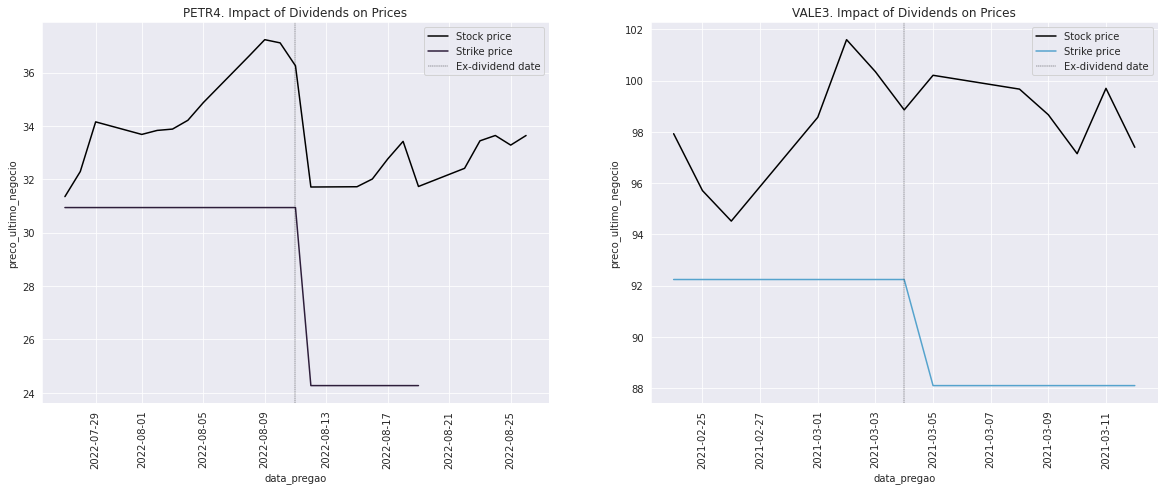

In [ ]:
plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
plot_dividend_diff(
    stock_df=petr4_stock_df_,
    call_df=petr4_call_df_,
    call_code="PETRH374",
    start_date=datetime(year=2022, month=7, day=27),
    ex_dividend_date=datetime(year=2022, month=8, day=11),
)
plt.title("PETR4. Impact of Dividends on Prices")

plt.subplot(1,2,2)
plot_dividend_diff(
    stock_df=vale3_stock_df_,
    call_df=vale3_call_df_,
    call_code="VALEC922",
    start_date=datetime(year=2021, month=2, day=24),
    ex_dividend_date=datetime(year=2021, month=3, day=4),
)
_ = plt.title("VALE3. Impact of Dividends on Prices")

At the ex-dividend dates, the dividends paid by the company are taken away from both stock price and strike price.

### Workaround
As a first approach, we'll consider that the dividends have never been paid. To do so, we'll add the value of the dividends to both stock and strike prices from the ex-dividend dates onwards.

In [ ]:
petr4_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/petr4_dividends.csv")
petr4_dividends_df.head(3)
for date_col in ["ex_date", "payment_date"]:
    petr4_dividends_df[date_col] = pd.to_datetime(petr4_dividends_df[date_col], format="%d/%m/%Y")

vale3_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/vale3_dividends.csv")
vale3_dividends_df.head(3)
for date_col in ["ex_date", "payment_date"]:
    vale3_dividends_df[date_col] = pd.to_datetime(vale3_dividends_df[date_col], format="%d/%m/%Y")

itub4_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/itub4_dividends.csv")
itub4_dividends_df.head(3)
for date_col in ["ex_date", "payment_date"]:
    vale3_dividends_df[date_col] = pd.to_datetime(vale3_dividends_df[date_col], format="%d/%m/%Y")

display(petr4_dividends_df.head(2))
display(vale3_dividends_df.head(2))
itub4_dividends_df.head(2)

,payment_date,ex_date,gross_dividend_paid,net_dividend_paid,dividend_type
0,2022-09-20,2022-08-11,3.366001,3.366001,Dividendo
1,2022-08-31,2022-08-11,0.427141,0.363070,JCP


,payment_date,ex_date,gross_dividend_paid,net_dividend_paid,dividend_type
0,2022-09-01,2022-08-11,2.0327,2.03270,Dividendo
1,2022-09-01,2022-08-11,1.5394,1.30849,JCP


,payment_date,ex_date,gross_dividend_paid,net_dividend_paid,dividend_type
0,08/12/2022,28/04/2023,0.48618,0.413253,JCP
1,18/08/2022,30/08/2022,0.30650,0.260525,JCP


In [ ]:
def rectify_dividends(
    df: pd.DataFrame,
    dividend_df: pd.DataFrame,
    price_column: str,
) -> pd.DataFrame:
    """
    Add the dividends to the price_column in df
    """

    rectified_df = df.copy()
    for _, dividend_row in dividend_df.iterrows():
      rectified_df[price_column] = rectified_df.apply(
          lambda row: row[price_column] + dividend_row["net_dividend_paid"]
          # Use >, because the reduction in the price due to dividends only occurs in the next day
          if row["data_pregao"] > dividend_row["ex_date"]
          else row[price_column],
          axis=1
      )

    return rectified_df

In [ ]:
petr4_dividends_per_ex_date_df = petr4_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()
vale3_dividends_per_ex_date_df = vale3_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()
itub4_dividends_per_ex_date_df = itub4_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()

# Stocks
petr4_stock_df = rectify_dividends(
    df=petr4_stock_df_,
    dividend_df=petr4_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)
vale3_stock_df = rectify_dividends(
    df=vale3_stock_df_,
    dividend_df=vale3_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)
itub4_stock_df = rectify_dividends(
    df=itub4_stock_df_,
    dividend_df=itub4_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)

# Calls
petr4_call_df = rectify_dividends(
    df=petr4_call_df_,
    dividend_df=petr4_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)
vale3_call_df = rectify_dividends(
    df=vale3_call_df_,
    dividend_df=vale3_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)
itub4_call_df = rectify_dividends(
    df=itub4_call_df_,
    dividend_df=itub4_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)

Let's compare the stock prices before and after adding the dividends.

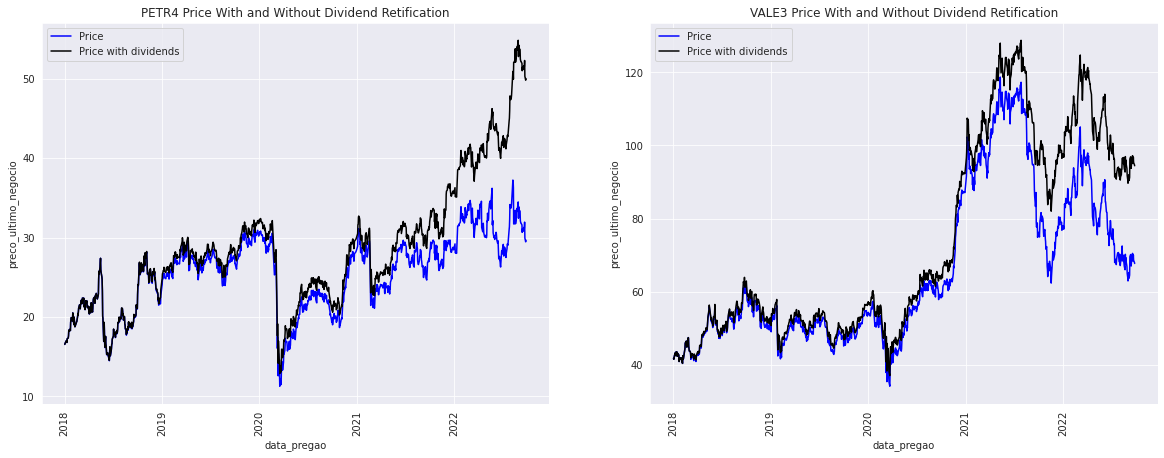

In [ ]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title("PETR4 Price With and Without Dividend Retification")
_ = sns.lineplot(
    data=petr4_stock_df_, y="preco_ultimo_negocio", x="data_pregao",
    label="Price", color='b'
)
_ = sns.lineplot(
    data=petr4_stock_df, y="preco_ultimo_negocio", x="data_pregao",
    label="Price with dividends", color='k'
)
_ = plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.title("VALE3 Price With and Without Dividend Retification")
_ = sns.lineplot(
    data=vale3_stock_df_, y="preco_ultimo_negocio", x="data_pregao",
    label="Price", color='b'
)
_ = sns.lineplot(
    data=vale3_stock_df, y="preco_ultimo_negocio", x="data_pregao",
    label="Price with dividends", color='k'
)
_ = plt.xticks(rotation='vertical')

After adding the dividends, we can verify now that they no longer change the stock and strike prices.

Strike price difference for PETRH374 from 2022-08-11 to 2022-08-12: -0.00 BRL
Strike price difference for VALEC922 from 2021-03-04 to 2021-03-05: -0.00 BRL


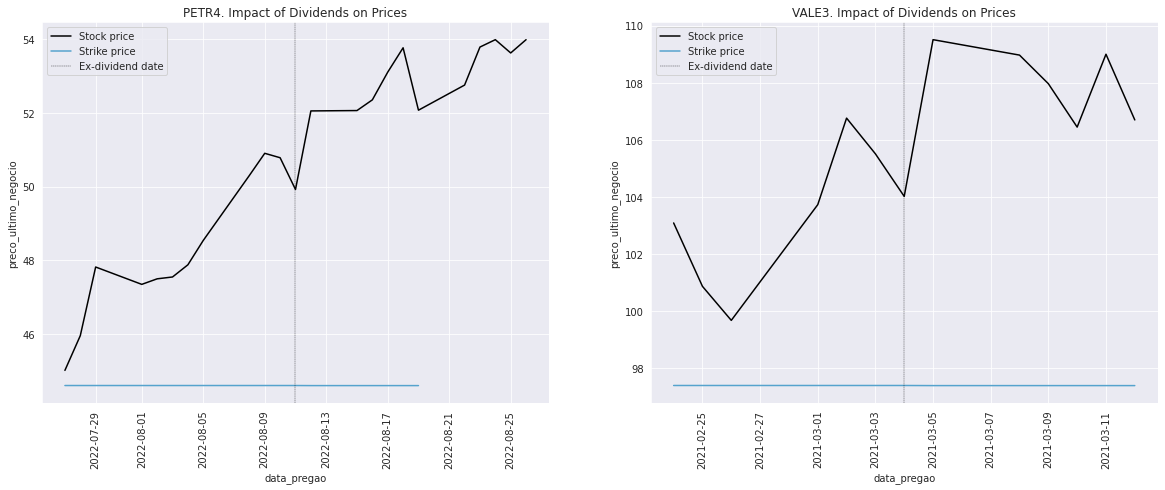

In [ ]:
plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
plot_dividend_diff(
    stock_df=petr4_stock_df,
    call_df=petr4_call_df,
    call_code="PETRH374",
    start_date=datetime(year=2022, month=7, day=27),
    ex_dividend_date=datetime(year=2022, month=8, day=11),
)
plt.title("PETR4. Impact of Dividends on Prices")

plt.subplot(1,2,2)
plot_dividend_diff(
    stock_df=vale3_stock_df,
    call_df=vale3_call_df,
    call_code="VALEC922",
    start_date=datetime(year=2021, month=2, day=24),
    ex_dividend_date=datetime(year=2021, month=3, day=4),
)
_ = plt.title("VALE3. Impact of Dividends on Prices")

### Save the Processed Data

In [ ]:
# Stocks
petr4_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/petr4_stock.csv", index=False)
vale3_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/vale3_stock.csv", index=False)
bova11_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/bova11_stock.csv", index=False)

# Calls
petr4_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/petr4_call.csv", index=False)
vale3_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/vale3_call.csv", index=False)
bova11_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/bova11_call.csv", index=False)

## Explore the Data
Here, we'll perform some studies to better understand the data and simulate some strategies.

### Load the Processed Data

In [ ]:
# Stocks
petr4_stock_df = pd.read_csv(
    DATA_FOLDER_PATH + "processed_data/petr4_stock.csv",
    parse_dates=["data_pregao"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
)
vale3_stock_df = pd.read_csv(
    DATA_FOLDER_PATH + "processed_data/vale3_stock.csv",
    parse_dates=["data_pregao"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
)
bova11_stock_df = pd.read_csv(
    DATA_FOLDER_PATH + "processed_data/bova11_stock.csv",
    parse_dates=["data_pregao"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
)

# Calls
petr4_call_df = pd.read_csv(
  DATA_FOLDER_PATH + "processed_data/petr4_call.csv",
  parse_dates=["data_pregao", "data_vencimento"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
)
vale3_call_df = pd.read_csv(
  DATA_FOLDER_PATH + "processed_data/vale3_call.csv",
  parse_dates=["data_pregao", "data_vencimento"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
)
bova11_call_df = pd.read_csv(
  DATA_FOLDER_PATH + "processed_data/bova11_call.csv",
  parse_dates=["data_pregao", "data_vencimento"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
)

# # Puts
# petr4_put_df = pd.read_csv(
#   DATA_FOLDER_PATH + "processed_data/petr4_put.csv",
#   parse_dates=["data_pregao", "data_vencimento"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
# )
# vale3_put_df = pd.read_csv(
#   DATA_FOLDER_PATH + "processed_data/vale3_put.csv",
#   parse_dates=["data_pregao", "data_vencimento"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
# )
# bova11_put_df = pd.read_csv(
#   DATA_FOLDER_PATH + "processed_data/bova11_put.csv",
#   parse_dates=["data_pregao", "data_vencimento"], date_parser=lambda date_str: datetime.strptime(date_str, '%Y-%m-%d')
# )

### Covered Call
The strategies we're going to simulate here are based in the European Covered Call strategy.
The idea is to by the stock and sell a call option for this asset with strike price higher than the stock price.
Two cases can happen at the expiration date:
* The stock price will be lower than the strike price at the expiration date. In this case the call turns to dust and we keep the stock and the premium.
* The stock price will be higher than the strike price. This mean we have to sell the stock by the strike price which bounds our profit.

To avoid code duplication and to keep the code cleaner, we'll implement the **strategy pattern** for the different covered call strategies. For the time being, the only between them is the way we pick the call option. Then, we will encapsulate what changes. 

In [ ]:
########## Exceptions ##########

class NoCompatibleCallOptionException(Exception):
    pass

class NoNegociationsOnDate(Exception):
    pass

########## Abstractions ##########
abstract_pick_call_strategy = Callable[
    [
        pd.DataFrame, # stock_df
        pd.DataFrame, # call_df
        datetime, # current_date
        datetime, # expiration_date
    ],
    pd.Series # call_option
] # Throws NoCompatibleCallOptionException

########## Schemas ##########

@dataclass
class CoveredCallResults:
  initial_amount: float
  final_amount: float
  strike_number: int # Number of times the stock price reached the strike price
  months_without_selling: int # Number of months where we couldn't find a proper call option
  average_strike_margin: float
  sd_strike_margin: float
  patrimony_over_time: List[float]

########## Utils ##########

def get_stock_price(
    stock_df: pd.DataFrame,
    date: datetime
) -> float:
    stock_price = stock_df[stock_df["data_pregao"] == date]["preco_ultimo_negocio"]
    if stock_price.shape[0] == 0: raise NoNegociationsOnDate(f"No negociations on date: {date}")
    return stock_price.iloc[0]

def simulate_covered_call(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    initial_amount: float,
    dates: List[datetime],
    pick_call_strategy: abstract_pick_call_strategy
) -> CoveredCallResults:

    amount_available = initial_amount
    n_stocks = 0
    strike_number = 0
    months_without_selling = 0
    strike_margins = []
    patrimony_over_time = []

    for i in tqdm(range(len(dates)-1), leave=False):
        ### Beginning of the cycle ###
        # Buy as many stocks as possible with the available amount
        price = stock_df[stock_df["data_pregao"] == dates[i]]["preco_ultimo_negocio"].iloc[0]
        n_new_stocks = math.floor(amount_available/price)
        n_stocks += n_new_stocks
        amount_available -= n_new_stocks * price
        patrimony_over_time.append(amount_available + (n_stocks * price))

        try:
            call_option = pick_call_strategy(
                stock_df,
                call_df,
                dates[i],
                dates[i+1],
            )
        except NoCompatibleCallOptionException as e:
            months_without_selling += 1
            continue

        # Acumulate the strike margins
        strike_margins.append(100 * (call_option["preco_exercicio"] - price) / price)
        # Sell the call option
        amount_available += n_stocks * call_option["preco_ultimo_negocio"]

        ### End of the cycle ###
        price = stock_df[stock_df["data_pregao"] == dates[i+1]]["preco_ultimo_negocio"].iloc[0]
        # If the stock price goes above the strike price, we are striked
        if price > call_option["preco_exercicio"]:
            # We have to sell all stocks by the strike price
            amount_available += n_stocks * call_option["preco_exercicio"]
            n_stocks = 0
            strike_number += 1

    patrimony_over_time.append(amount_available + (n_stocks * stock_df[stock_df["data_pregao"] == dates[-1]]["preco_ultimo_negocio"].iloc[0]))
    return CoveredCallResults(
        initial_amount=initial_amount,
        final_amount=patrimony_over_time[-1],
        strike_number=strike_number,
        months_without_selling=months_without_selling,
        average_strike_margin=statistics.mean(strike_margins),
        sd_strike_margin=statistics.stdev(strike_margins),
        patrimony_over_time=patrimony_over_time
    )

### Covered Call with Fixed Strike Margins

In [ ]:
def pick_call_strike_margin_strategy(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    current_date: datetime,
    expiration_date: datetime,

    volume_threshold: int,
    strike_margin: float,
    strike_margin_tolerance: float
) -> pd.Series:
    stock_price = get_stock_price(stock_df=stock_df, date=current_date)
    target_strike_price = stock_price * (1+strike_margin)

    # Filter call options traded at the current data and expire the next date
    filtered_call_df = call_df[
        (call_df["data_pregao"] == current_date)
        & (call_df["data_vencimento"] == expiration_date)
    ]
    if(filtered_call_df.shape[0] == 0):
        raise NoCompatibleCallOptionException(f"No option found at: {current_date} that expires at: {expiration_date}")

    # Find call option that have the closest strike prike to the one we want
    call_option = filtered_call_df.loc[
        (filtered_call_df["preco_exercicio"] - target_strike_price).abs().sort_values().index
    ].iloc[0]

    # Check if the best call option found complies with the constraints
    if(abs(call_option["preco_exercicio"] - target_strike_price)/stock_price > strike_margin_tolerance):
        raise NoCompatibleCallOptionException(
            "The strike price of the best call option found is too far from the target strike price"
            + f"Call option strike price: {call_option['preco_exercicio']} | Target strike price: {target_strike_price}"
        )
    if (call_option["volume_total_negociado"] < volume_threshold):
        raise NoCompatibleCallOptionException("Not enough negociations for the best call option found")
    
    return call_option


From: 2018-01-15T00:00:00.000000000 to 2022-08-19T00:00:00.000000000



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

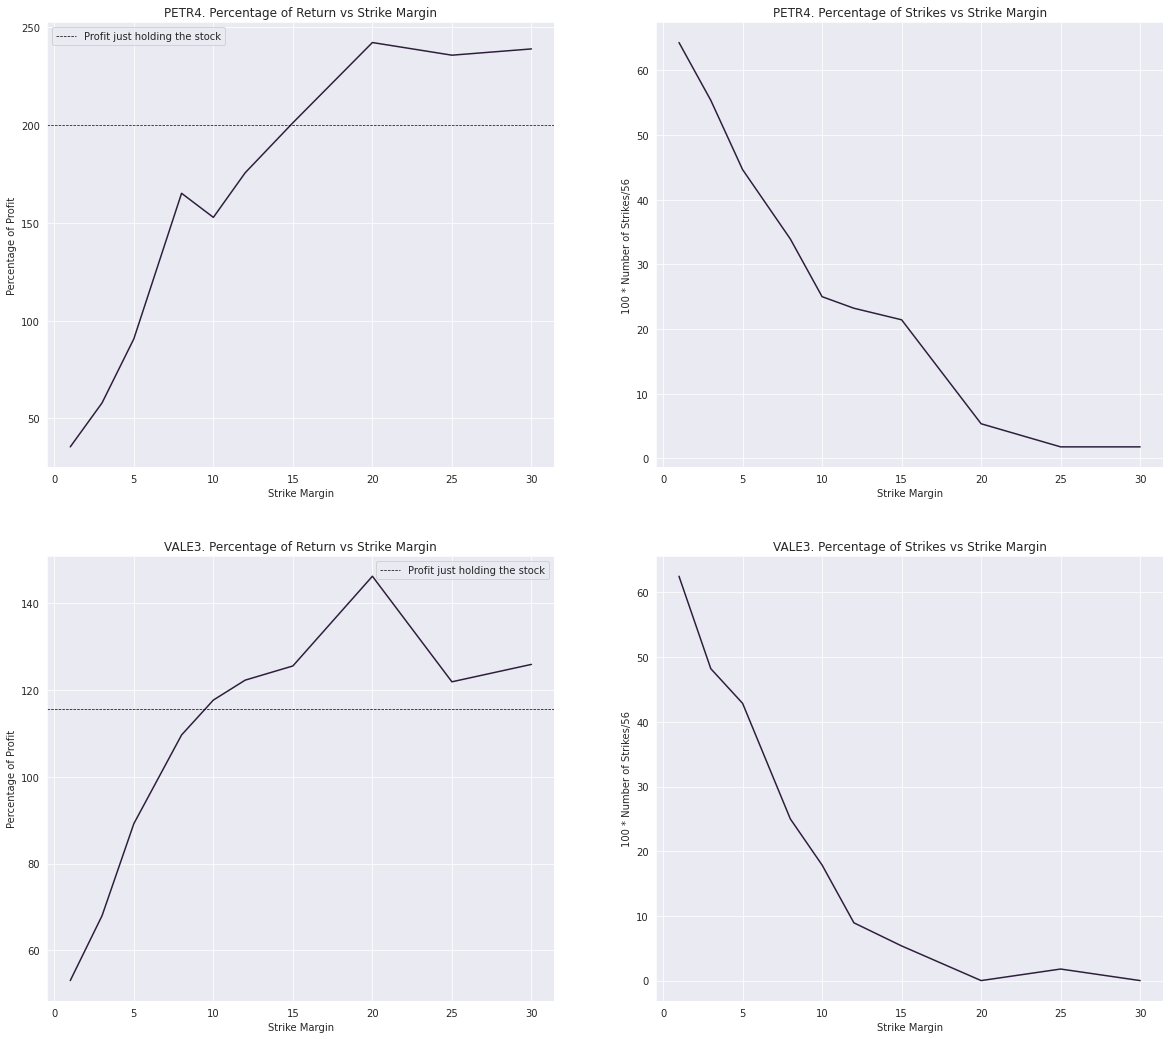

In [ ]:
initial_amount = 100_000.0
volume_threshold = 1000
strike_margin_tolerance = 0.03
strike_margins = [0.01, 0.03, 0.05, 0.08, 0.10, 0.12, 0.15, 0.20, 0.25, 0.3]
max_date = datetime(year=2022, month=8, day=31)
dates = petr4_call_df[petr4_call_df["data_vencimento"] <= max_date]["data_vencimento"].unique()
dates.sort()
print(f"From: {dates.min()} to {dates.max()}\n")

petr4_cov_call_profit_percentages = []
petr4_cov_call_strike_numbers = []
petr4_cov_call_patrimony_over_time_list = []
vale3_cov_call_profit_percentages = []
vale3_cov_call_strike_numbers = []
vale3_cov_call_patrimony_over_time_list = []

progress_bar = tqdm(strike_margins, leave=False)
for strike_margin in progress_bar:
    progress_bar.set_description(f"Strike margin at {100*strike_margin:.2f}%")

    pick_call_strategy=partial(
        pick_call_strike_margin_strategy,
        volume_threshold=volume_threshold,
        strike_margin=strike_margin,
        strike_margin_tolerance=strike_margin_tolerance
    )

    ### PETR4 ###
    petr4_results = simulate_covered_call(
        stock_df=petr4_stock_df,
        call_df=petr4_call_df,
        initial_amount=initial_amount,
        dates=dates,
        pick_call_strategy=pick_call_strategy
    )

    petr4_cov_call_profit_percentages.append(100*(petr4_results.final_amount - initial_amount)/initial_amount)
    petr4_cov_call_strike_numbers.append(100*petr4_results.strike_number/len(dates))
    petr4_cov_call_patrimony_over_time_list.append(petr4_results.patrimony_over_time)

    ### VALE3 ###

    vale3_results = simulate_covered_call(
        stock_df=vale3_stock_df,
        call_df=vale3_call_df,
        initial_amount=initial_amount,
        dates=dates,
        pick_call_strategy=pick_call_strategy
    )

    vale3_cov_call_profit_percentages.append(100*(vale3_results.final_amount - initial_amount)/initial_amount)
    vale3_cov_call_strike_numbers.append(100*vale3_results.strike_number/len(dates))
    vale3_cov_call_patrimony_over_time_list.append(vale3_results.patrimony_over_time)

result_holding_petr4 = 100 * (
    petr4_stock_df[petr4_stock_df["data_pregao"] == dates[-1]]["preco_ultimo_negocio"].iloc[0]
    - petr4_stock_df[petr4_stock_df["data_pregao"] == dates[0]]["preco_ultimo_negocio"].iloc[0]
)/petr4_stock_df[petr4_stock_df["data_pregao"] == dates[0]]["preco_ultimo_negocio"].iloc[0]

result_holding_vale3 = 100 * (
    vale3_stock_df[vale3_stock_df["data_pregao"] == dates[-1]]["preco_ultimo_negocio"].iloc[0]
    - vale3_stock_df[vale3_stock_df["data_pregao"] == dates[0]]["preco_ultimo_negocio"].iloc[0]
)/vale3_stock_df[vale3_stock_df["data_pregao"] == dates[0]]["preco_ultimo_negocio"].iloc[0]

##### Plot Graphs #####

plt.figure(figsize=(20,18))

plt.subplot(2, 2, 1)
_ = sns.lineplot(
    y=petr4_cov_call_profit_percentages, x=[100*strike_margin for strike_margin in strike_margins],
)
plt.axhline(
    y=result_holding_petr4, linestyle='--',
    linewidth=0.7, color="k", label="Profit just holding the stock"
) # type: ignore
plt.title("PETR4. Percentage of Return vs Strike Margin")
plt.ylabel("Percentage of Profit")
plt.xlabel("Strike Margin")
plt.legend()

plt.subplot(2, 2, 2)
_ = sns.lineplot(
    y=petr4_cov_call_strike_numbers, x=[100*strike_margin for strike_margin in strike_margins],
)
plt.title("PETR4. Percentage of Strikes vs Strike Margin")
plt.ylabel(f"100 * Number of Strikes/{len(dates)}")
_ = plt.xlabel("Strike Margin")

plt.subplot(2, 2, 3)
_ = sns.lineplot(
    y=vale3_cov_call_profit_percentages, x=[100*strike_margin for strike_margin in strike_margins],
)
plt.axhline(
    y=result_holding_vale3, linestyle='--',
    linewidth=0.7, color="k", label="Profit just holding the stock"
) # type: ignore
plt.title("VALE3. Percentage of Return vs Strike Margin")
plt.ylabel("Percentage of Profit")
plt.xlabel("Strike Margin")
plt.legend()

plt.subplot(2, 2, 4)
_ = sns.lineplot(
    y=vale3_cov_call_strike_numbers, x=[100*strike_margin for strike_margin in strike_margins],
)
plt.title("VALE3. Percentage of Strikes vs Strike Margin")
plt.ylabel(f"100 * Number of Strikes/{len(dates)}")
_ = plt.xlabel("Strike Margin")

# plt.subplot(3, 2, 5)
# for patrimony_over_time, strike_margin in zip(petr4_cov_call_patrimony_over_time_list, strike_margins):
#     _ = sns.lineplot(
#         y=patrimony_over_time, x=dates,
#         label=f"Strike margin: {strike_margin}"
#     )
# plt.title("PETR4. Patrimony Over Time")
# plt.ylabel("Patrimony BRL")
# _ = plt.xlabel("Date")

# plt.subplot(3, 2, 6)
# for patrimony_over_time, strike_margin in zip(vale3_cov_call_patrimony_over_time_list, strike_margins):
#     _ = sns.lineplot(
#         y=patrimony_over_time, x=dates,
#         label=f"Strike margin: {strike_margin}"
#     )
# plt.title("VALE3. Patrimony Over Time")
# plt.ylabel("Patrimony BRL")
# _ = plt.xlabel("Date")

### Volatility

#### Historical Volatility
Our measure of volatility will be the anual historical standard deviation of the stock price. Usually, we can calculate it as the following.  

$$DailyReturn_i = {StockPrice_{i+1} - StockPrice_{i} \over StockPrice_{i}}$$  

$$ AnnualHistoricalSD = \sqrt{252} * \sqrt{\sum_{i=1}^{n}(DailyReturn_i - \overline{DailyReturn})^2 \over n - 1}$$

However, as we'll see later, we want to compare the historical volatility with the implied one by the Black-Scholes Model. To do so, we have to make the following change in the way the daily return is calculated.

$$DailyReturn_i = ln({StockPrice_{i+1} - StockPrice_{i} \over StockPrice_{i}})$$  

In [ ]:
def annualized_hist_volatility(
    stock_df: pd.DataFrame,
    end_date: datetime = datetime(year=2022, month=7, day=4),
    offset: int = 20 # How far in the past
) -> float:
    end_idx = stock_df[stock_df["data_pregao"] == end_date].index[0]
    df = stock_df.iloc[max(0, end_idx-offset+1):end_idx+1]
    return np.log(df["preco_ultimo_negocio"]/df["preco_ultimo_negocio"].shift(1)).std()*math.sqrt(252)

print(
    f"PETR4 Annualized Volatility: {100*annualized_hist_volatility(petr4_stock_df, end_date=petr4_stock_df['data_pregao'].max(), offset=petr4_stock_df.shape[0]):.2f}%\n"
)
print(
    f"VALE3 Annualized Volatility: {100*annualized_hist_volatility(vale3_stock_df, end_date=vale3_stock_df['data_pregao'].max(), offset=vale3_stock_df.shape[0]):.2f}%"
)

PETR4 Annualized Volatility: 46.19%

VALE3 Annualized Volatility: 38.12%


#### Implied Volatility

##### Black-Scholes Model
The Black-Scholes formula gives the fair price for a call option.

$$d_1 = ln({S \over K} + T(r + {\sigma^2 \over 2}))$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

$$Call = SN(d_1) −N(d_2)Ke^{-rT}$$

Where
* S: current asset price
* K: strike price of the option
* r: annualized risk free rate
* T: time until option expiration in years
* $\sigma$: annualized volatility of the asset's returns
* N(x): is the cumulative distribution function for a standard normal distribution

$$N(x) = {1 \over 2\pi}\int_{-\infty}^{x}e^{-z^2/2}dz$$

##### What's Implied Volatility
Given S, K, r, T and a call price that was taken from the exchange, meaning a fair price, since the market is efficient, we can solve the Black-Scholes formula to find $\sigma$. This $\sigma$ is the implied volatility and it represents the volatility the stock is supposed to have to keep the call price fair according to the market.

In [ ]:
def black_scholes_call(
    stock_price: float,
    strike_price: float,
    time_to_maturity: float,
    risk_free_rate: float,
    volatility: float
) -> float:
    """Calculate the call price
    """

    # Standard black-scholes formula
    d1 = (
        np.log(stock_price / strike_price) + (risk_free_rate + volatility ** 2 / 2) * time_to_maturity
    ) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)

    return stock_price * norm.cdf(d1) -  norm.cdf(d2)* strike_price * np.exp(-risk_free_rate * time_to_maturity)

def vega(
    stock_price: float,
    strike_price: float,
    time_to_maturity: float,
    risk_free_rate: float,
    volatility: float
) -> float:
    """Calculate partial derivative w.r.t volatility
    """

    # Calculate d1 from black scholes
    d1 = (
        np.log(stock_price / strike_price) + (risk_free_rate + volatility ** 2 / 2) * time_to_maturity
    ) / volatility * np.sqrt(time_to_maturity)
    
    return stock_price  * np.sqrt(time_to_maturity) * norm.pdf(d1)

def implied_volatility_call(
    call_price: float,
    stock_price: float,
    strike_price: float,
    time_to_maturity: float,
    risk_free_rate: float,
    tol: float = 0.0001,
    max_iterations: int = 100
) -> float:
    """Calculate the implied volatility in percent
    """

    # Initial volatility estimate for input in Newton_rap procedure
    volatility = 0.3
    
    for i in range(max_iterations):
        
        # Calculate difference between blackscholes price and market price with
        # iteratively updated volality estimate
        diff = black_scholes_call(stock_price, strike_price, time_to_maturity, risk_free_rate, volatility) - call_price

        # Break if difference is less than specified tolerance level
        if abs(diff) < tol:
            # print(f"Found on the {i}th iteration. The difference is equal to {diff}")
            break

        # Update the estimate with Newton Rapshon 
        volatility = volatility - diff / vega(stock_price, strike_price, time_to_maturity, risk_free_rate, volatility)

    return volatility

def calculate_implied_volatilities(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    dates: pd.Series,
) -> List[float]:
    annualized_implied_vols = []
    for i in range(len(dates)-1):
        stock_price = stock_df[
            stock_df["data_pregao"] == dates[i]
        ]["preco_ultimo_negocio"].iloc[0]

        filtered_call_df = call_df[
            (call_df["data_pregao"] == dates[i])
            & (call_df["data_vencimento"] == dates[i+1])
        ]
        # Choose call that has the strike price the closest to the stock price
        call_option = filtered_call_df.loc[
            (filtered_call_df["preco_exercicio"] - stock_price).abs().sort_values().index[0]
        ]

        annualized_implied_vols.append(implied_volatility_call(
          call_price=call_option["preco_ultimo_negocio"],
          stock_price=stock_price,
          strike_price=call_option["preco_exercicio"],
          time_to_maturity=(dates[i+1] - dates[i]).astype('timedelta64[D]').astype(int)/365,
          risk_free_rate=get_current_selic(date=dates[i])
        ))

    return annualized_implied_vols

#### Selic Rate

In Brazil, the interest risk-free rate is the Selic rate.

In [ ]:
selic_df = pd.read_csv(DATA_FOLDER_PATH + "selic.csv")
selic_df["release_date"] = pd.to_datetime(selic_df["release_date"], format="%d/%m/%Y")

def get_current_selic(date: datetime) -> float:
    return selic_df[selic_df["release_date"] <= date]["selic"].iloc[0]/100

selic_df.head(3)

,release_date,duration,meta,selic
0,2022-08-03,04/08/2022 - 21/09/2022,13.75,13.65
1,2022-06-15,17/06/2022 - 03/08/2022,13.25,13.15
2,2022-05-04,05/05/2022 - 16/06/2022,12.75,12.65


#### Implied vs Historical

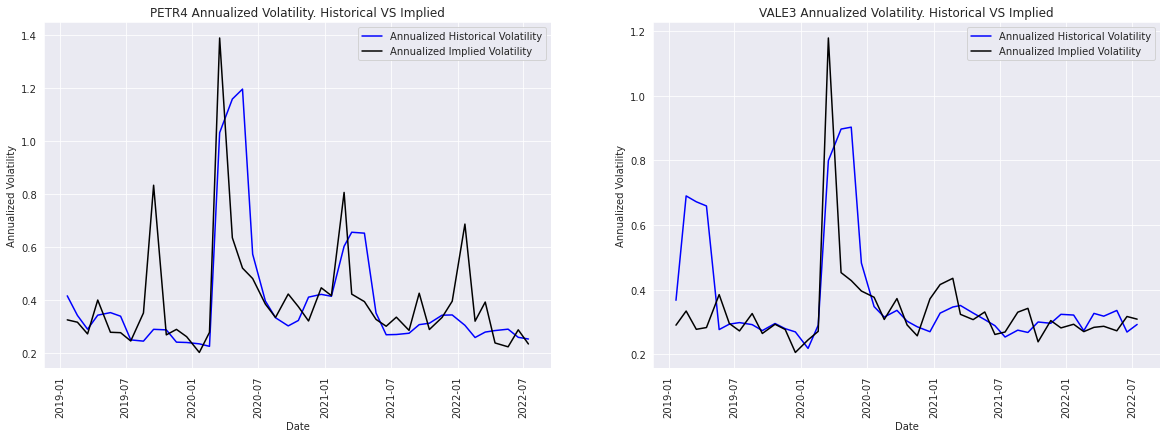

In [ ]:
last_n_working_days = 60
min_date = datetime(year=2019, month=1, day=1) # Make sure there are at least 'last_n_working_days' days prior to min_date
max_date = datetime(year=2022, month=8, day=31)
dates = petr4_call_df[petr4_call_df["data_vencimento"].between(min_date, max_date)]["data_vencimento"].unique()
dates.sort()

##### Historical Volatilities #####
petr4_annualized_hist_vols = []
vale3_annualized_hist_vols = []
for date in dates[:-1]:
    petr4_annualized_hist_vols.append(
        annualized_hist_volatility(petr4_stock_df, end_date=date, offset=last_n_working_days)
    )
    vale3_annualized_hist_vols.append(
        annualized_hist_volatility(vale3_stock_df, end_date=date, offset=last_n_working_days)
    )

##### Implied Volatilities #####
petr4_annualized_implied_vols = calculate_implied_volatilities(
    stock_df=petr4_stock_df,
    call_df=petr4_call_df,
    dates=dates,
)
vale3_annualized_implied_vols = calculate_implied_volatilities(
    stock_df=vale3_stock_df,
    call_df=vale3_call_df,
    dates=dates,
)

##### Graphs #####
plt.figure(figsize=(20,14))

plt.subplot(2, 2, 1)
_ = sns.lineplot(
    y=petr4_annualized_hist_vols, x=dates[:-1],
    label="Annualized Historical Volatility", color="b"
)
_ = sns.lineplot(
    y=petr4_annualized_implied_vols, x=dates[:-1],
    label="Annualized Implied Volatility", color="k"
)
plt.title("PETR4 Annualized Volatility. Historical VS Implied")
plt.ylabel(f"Annualized Volatility")
_ = plt.xlabel("Date")
_ = plt.xticks(rotation="vertical")

plt.subplot(2, 2, 2)
_ = sns.lineplot(
    y=vale3_annualized_hist_vols, x=dates[:-1],
    label="Annualized Historical Volatility", color="b"
)
_ = sns.lineplot(
    y=vale3_annualized_implied_vols, x=dates[:-1],
    label="Annualized Implied Volatility", color="k"
)
plt.title("VALE3 Annualized Volatility. Historical VS Implied")
plt.ylabel(f"Annualized Volatility")
_ = plt.xlabel("Date")
_ = plt.xticks(rotation="vertical")

### Covered Call with Fixed Volatility Margins

Here we'll use the volatility as a measure to pick the best call option in a given month

In [ ]:
def pick_call_closest_volatility_margin_strategy(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    current_date: datetime,
    expiration_date: datetime,
    volatility_margin: float,
    last_n_working_days: int,
    strike_margin_threshold: float,
) -> pd.Series:
    stock_price = get_stock_price(stock_df=stock_df, date=current_date)
    hist_volatility = annualized_hist_volatility(stock_df, end_date=current_date, offset=last_n_working_days)

    # Filter call options traded at the current data and expire the next date
    filtered_call_df = call_df[
        (call_df["data_pregao"] == current_date)
        & (call_df["data_vencimento"] == expiration_date)
        & (call_df["preco_exercicio"] > stock_price * (1 + strike_margin_threshold))
    ]
    if(filtered_call_df.shape[0] == 0):
        raise NoCompatibleCallOptionException(f"No option found at: {current_date} that expires at: {expiration_date}")

    call_volatility_margins = filtered_call_df.apply(lambda row:
        (implied_volatility_call(
            call_price=row["preco_ultimo_negocio"],
            stock_price=stock_price,
            strike_price=row["preco_exercicio"],
            time_to_maturity=(row["data_vencimento"] - current_date).days/365,
            risk_free_rate=get_current_selic(date=current_date),
        ) - hist_volatility)/hist_volatility,
        axis=1
    )

    call_volatility_margin_distances = (call_volatility_margins - volatility_margin).abs()

    call_df = call_df.filter(items = call_volatility_margin_distances.index, axis=0)
    min_distance_idx = call_volatility_margin_distances.idxmin()

    return call_df.loc[min_distance_idx]

def pick_call_volatility_margin_strategy(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    current_date: datetime,
    expiration_date: datetime,
    volatility_margin: float,
    last_n_working_days: int,
    strike_margin_threshold: float,
    tolerance: float,
) -> pd.Series:
    """
    Pick the call option in `call_df` that has implied volatility higher than the historical one
    by approximately `volatility_margin`%.
    We only consider call options that have volatility margin inside the range
    [volatility_margin - tolerance, volatility_margin + tolerance]. If more than one call is found,
    we take the one with highest premium.
    """
    stock_price = get_stock_price(stock_df=stock_df, date=current_date)
    hist_volatility = annualized_hist_volatility(stock_df, end_date=current_date, offset=last_n_working_days)

    # Filter call options traded at the current data and expire the next date
    filtered_call_df = call_df[
        (call_df["data_pregao"] == current_date)
        & (call_df["data_vencimento"] == expiration_date)
        & (call_df["preco_exercicio"] > stock_price * (1 + strike_margin_threshold))
    ]
    if(filtered_call_df.shape[0] == 0):
        raise NoCompatibleCallOptionException(f"No option found at: {current_date} that expires at: {expiration_date}")

    call_volatility_margins = filtered_call_df.apply(lambda row:
        (implied_volatility_call(
            call_price=row["preco_ultimo_negocio"],
            stock_price=stock_price,
            strike_price=row["preco_exercicio"],
            time_to_maturity=(row["data_vencimento"] - current_date).days/365,
            risk_free_rate=get_current_selic(date=current_date),
        ) - hist_volatility)/hist_volatility,
        axis=1
    )

    call_volatility_margin_distances = (call_volatility_margins - volatility_margin).abs()
    # Remove call options that have volatility margin too far from the target 
    call_volatility_margin_distances = call_volatility_margin_distances[call_volatility_margin_distances < tolerance]
    
    if(call_volatility_margin_distances.size == 0):
      raise NoCompatibleCallOptionException(f"No call option found for the volatility margin: {volatility_margin}")

    call_df = call_df.filter(items = call_volatility_margin_distances.index, axis=0)
    max_premium_idx = call_df["preco_ultimo_negocio"].idxmax()

    return call_df.loc[max_premium_idx]


From: 2018-01-15T00:00:00.000000000 to 2022-08-19T00:00:00.000000000



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

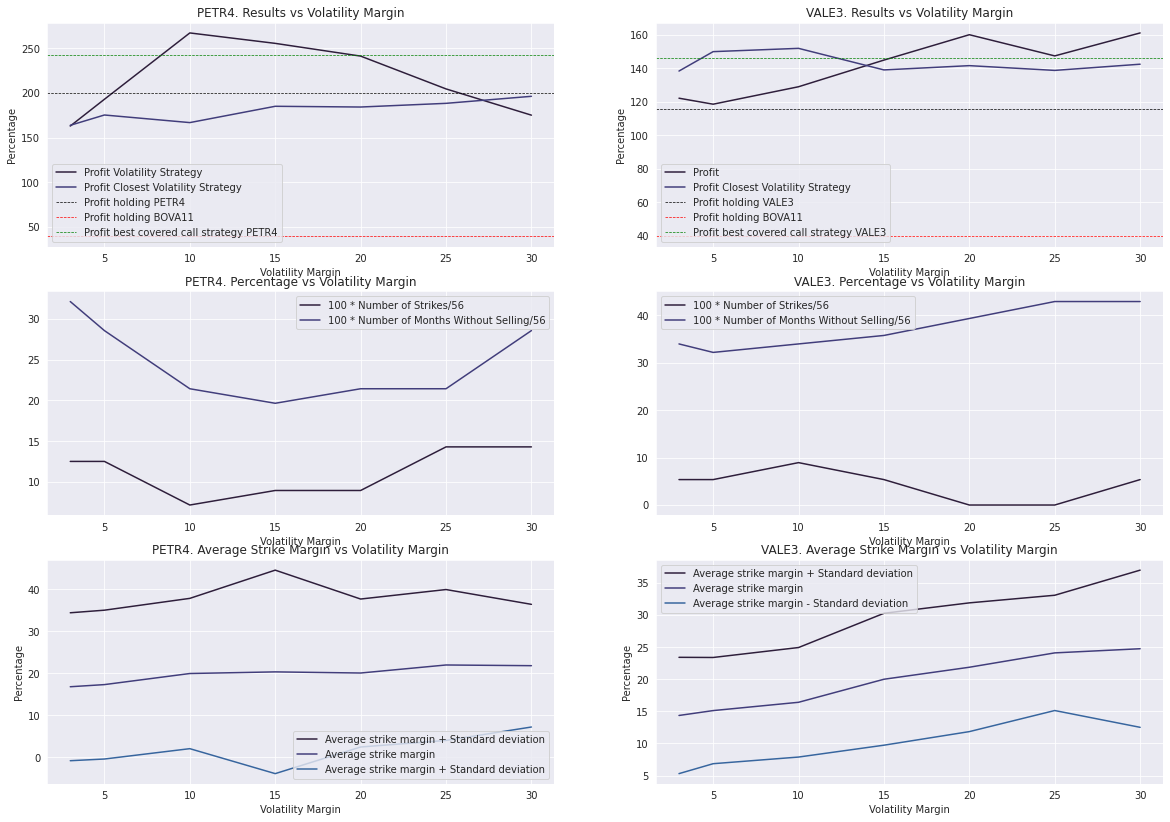

In [ ]:
volatility_margins = [0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
# volatility_margins = [0.1, 0.15,]
last_n_working_days = 60
strike_margin_threshold = 0.05
tolerance = 0.05
initial_amount = 100_000.0
max_date = datetime(year=2022, month=8, day=31)
dates = petr4_call_df[petr4_call_df["data_vencimento"] <= max_date]["data_vencimento"].unique()
dates.sort()
print(f"From: {dates.min()} to {dates.max()}\n")

##### Volatility Strategy #####
petr4_closest_vol_results = []
petr4_vol_results = []
vale3_closest_vol_results = []
vale3_vol_results = []

progress_bar = tqdm(volatility_margins)
for volatility_margin in progress_bar:
    progress_bar.set_description(f"Volatility margin at {100*volatility_margin:.2f}%")

    pick_call_closest_vol_strategy = partial(
        pick_call_closest_volatility_margin_strategy,
        volatility_margin=volatility_margin,
        last_n_working_days=last_n_working_days,
        strike_margin_threshold=strike_margin_threshold,
    )
    pick_call_vol_strategy = partial(
        pick_call_volatility_margin_strategy,
        volatility_margin=volatility_margin,
        last_n_working_days=last_n_working_days,
        strike_margin_threshold=strike_margin_threshold,
        tolerance=tolerance,
    )

    ### PETR4 ###
    petr4_closest_vol_results.append(simulate_covered_call(
        stock_df=petr4_stock_df,
        call_df=petr4_call_df,
        initial_amount=initial_amount,
        dates=dates,
        pick_call_strategy=pick_call_closest_vol_strategy
    ))
    petr4_vol_results.append(simulate_covered_call(
        stock_df=petr4_stock_df,
        call_df=petr4_call_df,
        initial_amount=initial_amount,
        dates=dates,
        pick_call_strategy=pick_call_vol_strategy
    ))

    ### VALE3 ###
    vale3_closest_vol_results.append(simulate_covered_call(
        stock_df=vale3_stock_df,
        call_df=vale3_call_df,
        initial_amount=initial_amount,
        dates=dates,
        pick_call_strategy=pick_call_closest_vol_strategy
    ))
    vale3_vol_results.append(simulate_covered_call(
        stock_df=vale3_stock_df,
        call_df=vale3_call_df,
        initial_amount=initial_amount,
        dates=dates,
        pick_call_strategy=pick_call_vol_strategy
    ))

##### Evolution of the patrimony with Buy and Hold #####
n_stocks = initial_amount/petr4_stock_df[petr4_stock_df["data_pregao"] == dates[0]]["preco_ultimo_negocio"].iloc[0]
petr4_results_holding_stock = []
for date in dates:
    petr4_results_holding_stock.append(
        n_stocks*petr4_stock_df[petr4_stock_df["data_pregao"] == date]["preco_ultimo_negocio"].iloc[0]
    )
petr4_stock_return = (petr4_results_holding_stock[-1] - petr4_results_holding_stock[0])/petr4_results_holding_stock[0]

n_stocks = initial_amount/vale3_stock_df[vale3_stock_df["data_pregao"] == dates[0]]["preco_ultimo_negocio"].iloc[0]
vale3_results_holding_stock = []
for date in dates:
    vale3_results_holding_stock.append(
        n_stocks*vale3_stock_df[vale3_stock_df["data_pregao"] == date]["preco_ultimo_negocio"].iloc[0]
    )
vale3_stock_return = (vale3_results_holding_stock[-1] - vale3_results_holding_stock[0])/vale3_results_holding_stock[0]

n_stocks = initial_amount/bova11_stock_df[bova11_stock_df["data_pregao"] == dates[0]]["preco_ultimo_negocio"].iloc[0]
bova11_results_holding_stock = []
for date in dates:
    bova11_results_holding_stock.append(
        n_stocks*bova11_stock_df[bova11_stock_df["data_pregao"] == date]["preco_ultimo_negocio"].iloc[0]
    )
bova11_stock_return = (bova11_results_holding_stock[-1] - bova11_results_holding_stock[0])/bova11_results_holding_stock[0]

##### Calculate return with the best Covered Call Strategy #####
petr4_covered_call_max_idx = 0
for idx, p in enumerate(petr4_cov_call_patrimony_over_time_list):
    if p[-1] >= petr4_cov_call_patrimony_over_time_list[petr4_covered_call_max_idx][-1]:
        petr4_covered_call_max_idx = idx
petr4_covered_call_return = (
    petr4_cov_call_patrimony_over_time_list[petr4_covered_call_max_idx][-1] - initial_amount
)/initial_amount

vale3_covered_call_max_idx = 0
for idx, p in enumerate(vale3_cov_call_patrimony_over_time_list):
    if p[-1] >= vale3_cov_call_patrimony_over_time_list[vale3_covered_call_max_idx][-1]:
        vale3_covered_call_max_idx = idx
vale3_covered_call_return = (
    vale3_cov_call_patrimony_over_time_list[vale3_covered_call_max_idx][-1] - initial_amount
)/initial_amount

##### Graphs #####
plt.figure(figsize=(20,14))

### PETR4 ###

plt.subplot(3, 2, 1)

_ = sns.lineplot(
    y=[100*(result.final_amount - initial_amount)/initial_amount for result in petr4_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Profit Volatility Strategy"
)
_ = sns.lineplot(
    y=[100*(result.final_amount - initial_amount)/initial_amount for result in petr4_closest_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Profit Closest Volatility Strategy"
)
plt.axhline(
    y=100*petr4_stock_return, linestyle='--',
    linewidth=0.7, color="k", label="Profit holding PETR4"
) # type: ignore
plt.axhline(
    y=100*bova11_stock_return, linestyle='--',
    linewidth=0.7, color="r", label="Profit holding BOVA11"
) # type: ignore
plt.axhline(
    y=100*petr4_covered_call_return, linestyle='--',
    linewidth=0.7, color="g", label="Profit best covered call strategy PETR4"
) # type: ignore
plt.title("PETR4. Results vs Volatility Margin")
plt.ylabel("Percentage")
plt.xlabel("Volatility Margin")
plt.legend()

plt.subplot(3, 2, 3)

_ = sns.lineplot(
    y=[100*result.strike_number/len(dates) for result in petr4_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label=f"100 * Number of Strikes/{len(dates)}"
)
_ = sns.lineplot(
    y=[100*result.months_without_selling/len(dates) for result in petr4_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label=f"100 * Number of Months Without Selling/{len(dates)}"
)
plt.title("PETR4. Percentage vs Volatility Margin")
_ = plt.xlabel("Volatility Margin")

plt.subplot(3, 2, 5)

_ = sns.lineplot(
    y=[result.average_strike_margin + result.sd_strike_margin for result in petr4_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Average strike margin + Standard deviation"
)
_ = sns.lineplot(
    y=[result.average_strike_margin for result in petr4_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Average strike margin"
)
_ = sns.lineplot(
    y=[result.average_strike_margin - result.sd_strike_margin for result in petr4_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Average strike margin + Standard deviation"
)
plt.title("PETR4. Average Strike Margin vs Volatility Margin")
plt.ylabel(f"Percentage")
_ = plt.xlabel("Volatility Margin")

### VALE3 ###

plt.subplot(3, 2, 2)

_ = sns.lineplot(
    y=[100*(result.final_amount - initial_amount)/initial_amount for result in vale3_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Profit"
)
_ = sns.lineplot(
    y=[100*(result.final_amount - initial_amount)/initial_amount for result in vale3_closest_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Profit Closest Volatility Strategy"
)
plt.axhline(
    y=100*vale3_stock_return, linestyle='--',
    linewidth=0.7, color="k", label="Profit holding VALE3"
) # type: ignore
plt.axhline(
    y=100*bova11_stock_return, linestyle='--',
    linewidth=0.7, color="r", label="Profit holding BOVA11"
) # type: ignore
plt.axhline(
    y=100*vale3_covered_call_return, linestyle='--',
    linewidth=0.7, color="g", label="Profit best covered call strategy VALE3"
) # type: ignore
plt.title("VALE3. Results vs Volatility Margin")
plt.ylabel("Percentage")
plt.xlabel("Volatility Margin")
plt.legend()

plt.subplot(3, 2, 4)

_ = sns.lineplot(
    y=[100*result.strike_number/len(dates) for result in vale3_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label=f"100 * Number of Strikes/{len(dates)}"
)
_ = sns.lineplot(
    y=[100*result.months_without_selling/len(dates) for result in vale3_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label=f"100 * Number of Months Without Selling/{len(dates)}"
)
plt.title("VALE3. Percentage vs Volatility Margin")
_ = plt.xlabel("Volatility Margin")

plt.subplot(3, 2, 6)

_ = sns.lineplot(
    y=[result.average_strike_margin + result.sd_strike_margin for result in vale3_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Average strike margin + Standard deviation"
)
_ = sns.lineplot(
    y=[result.average_strike_margin for result in vale3_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Average strike margin"
)
_ = sns.lineplot(
    y=[result.average_strike_margin - result.sd_strike_margin for result in vale3_vol_results],
    x=[100*volatility_margin for volatility_margin in volatility_margins],
    label="Average strike margin - Standard deviation"
)
plt.title("VALE3. Average Strike Margin vs Volatility Margin")
plt.ylabel(f"Percentage")
_ = plt.xlabel("Volatility Margin")

### Intrinsic and Extrinsic Values

The value of an option consists of two parts: Intrinsic and Extrinsic.  
On the one hand, the intrinsic value of an options is the difference between the price of the underlying asset and the strike price of the option. The instrinsic value reflects the real value of an option and doesn't change with time. Here below, we have the equation to calculate the intrinsec value of a call and a put. It is worth noticing that the intrinsic value of a call is zero if the current stock price is less than the strike price. In this case, it is better for you to buy the stock directly instead of using the call (buy option), then the call is useless. A similar logic applies to the put options, since a put is worthless if the current stock price is higher than the strike price.

$$IV_c = max(S-K,0)$$
$$IV_p = max(K-S,0)$$

On the other hand, the extrinsic value is the value generated by the incertainty the time remaining on the contract and the implied volatility of the stock cause. The extrinsic value is the difference between the premium and the intrinsic value and decays with time.

$$EV_c = P_c - IV_c$$
$$EV_p = P_p - IV_p$$

In [ ]:
%%script false --no-raise-error
def calculate_intrinsic_value(
    option_df: pd.DataFrame,
    stock_df: pd.DataFrame,
    is_call: bool
) -> None:
    option_df["valor_intrinseco"] = option_df.apply(
        lambda row: max(
            stock_df[stock_df["data_pregao"] == row["data_pregao"]]["preco_ultimo_negocio"].iloc[0] - row["preco_exercicio"]
            if is_call
            else row["preco_exercicio"] - stock_df[stock_df["data_pregao"] == row["data_pregao"]]["preco_ultimo_negocio"].iloc[0],
            0
        ),
        axis=1
    )


### Calls ###
calculate_intrinsic_value(petr4_call_df, petr4_stock_df, is_call=True)
calculate_intrinsic_value(vale3_call_df, vale3_stock_df, is_call=True)

petr4_call_df["valor_extrinseco"] = petr4_call_df["preco_ultimo_negocio"] - petr4_call_df["valor_intrinseco"]
vale3_call_df["valor_extrinseco"] = vale3_call_df["preco_ultimo_negocio"] - vale3_call_df["valor_intrinseco"]

### Puts ###
calculate_intrinsic_value(petr4_put_df, vale3_stock_df, is_call=False)
calculate_intrinsic_value(vale3_put_df, vale3_stock_df, is_call=False)

petr4_put_df["valor_extrinseco"] = petr4_put_df["preco_ultimo_negocio"] - petr4_put_df["valor_intrinseco"]
vale3_put_df["valor_extrinseco"] = vale3_put_df["preco_ultimo_negocio"] - vale3_put_df["valor_intrinseco"]


In [ ]:
petr4_call_df

,data_pregao,cod_negociacao,tipo_mercado,preco_abertura,preco_ultimo_negocio,volume_total_negociado,preco_exercicio,data_vencimento,valor_intrinseco,valor_extrinseco
0,2018-01-02,PETRA10,70,6.53,6.53,6530.0,10.000000,2018-01-15,6.55,-0.02
1,2018-01-02,PETRC21,70,0.07,0.09,94.0,21.000000,2018-03-19,0.00,0.09
2,2018-01-02,PETRC20,70,0.10,0.14,99.0,20.000000,2018-03-19,0.00,0.14
3,2018-01-02,PETRC19,70,0.24,0.26,22317.0,19.000000,2018-03-19,0.00,0.26
4,2018-01-02,PETRC18,70,0.39,0.45,12268.0,18.000000,2018-03-19,0.00,0.45
...,...,...,...,...,...,...,...,...,...,...
244309,2022-09-27,PETRL366,70,6.14,6.09,526263.0,45.110206,2022-12-16,4.90,1.19
244310,2022-09-27,PETRK304,70,12.62,12.74,392622.0,37.610206,2022-11-18,12.40,0.34
244311,2022-09-27,PETRA391,70,5.88,5.88,1764.0,46.360206,2023-01-20,3.65,2.23
244312,2022-09-27,PETRD450,70,3.80,3.55,683616.0,52.110206,2023-04-20,0.00,3.55


### Covered Call With Machine Learning

#### Features
* [X] Implied and Historical Volatility ratio.
* [X] Strike Margin.
* [X] Premium or how much the premium can protect you.
* [ ] Number of months in the past where S went above K for a given call and a given month.
* [ ] Something related to the moving average.

#### Output
Whether or not the call will outperform Buy and Hold if applied in a covered call strategy.  
We could calculate the probability for every one and pick the most-likely one.


#### Dataset

In [ ]:
def calculate_single_month_cc_return(row: pd.Series, stock_df: pd.DataFrame,):
    try:
        current_stock_price = get_stock_price(stock_df=stock_df, date=row["data_pregao"])
        next_month_stock_price = get_stock_price(stock_df=stock_df, date=row["data_vencimento"])
    except NoNegociationsOnDate as e:
        return np.nan

    # print(f"Price at {row['data_pregao']}: {current_stock_price} | Price at {row['data_vencimento']}: {next_month_stock_price}")

    initial_amount = current_stock_price + row["preco_ultimo_negocio"]
    final_amount = min(next_month_stock_price, row["preco_exercicio"]) + row["preco_ultimo_negocio"]
    # print(f"Initial Amount: {initial_amount} | Final Amount: {final_amount}\n\n")

    return (final_amount - initial_amount)/initial_amount

In [ ]:
last_n_working_days = 60
start_date = datetime(year=2019, month=1, day=1)
max_date = datetime(year=2022, month=8, day=31)
dates = petr4_call_df[petr4_call_df["data_vencimento"] <= max_date]["data_vencimento"].unique()
dates.sort()
print(f"From: {dates.min()} to {dates.max()}\n")

filtered_petr4_call_df = petr4_call_df[petr4_call_df["data_pregao"].isin(dates) & (petr4_call_df["data_pregao"] > start_date)]
petr4_ml_df_ = pd.DataFrame()

### Date ###
petr4_ml_df_["date"] = filtered_petr4_call_df["data_pregao"]

### Volatility ###
petr4_ml_df_["implied_volatility"] = filtered_petr4_call_df.apply(lambda row: implied_volatility_call(
    call_price=row["preco_ultimo_negocio"],
    stock_price=get_stock_price(petr4_stock_df, row["data_pregao"]),
    strike_price=row["preco_exercicio"],
    time_to_maturity=(row["data_vencimento"] - row["data_pregao"]).days/365,
    risk_free_rate=get_current_selic(row["data_pregao"]),
), axis=1)

petr4_ml_df_["hist_volatility"] = filtered_petr4_call_df.apply(
    lambda row: annualized_hist_volatility(
        petr4_stock_df,
        end_date=row["data_pregao"],
        offset=last_n_working_days
    ),
    axis=1
)

petr4_ml_df_["volatility_margin"] = (
    petr4_ml_df_["implied_volatility"] - petr4_ml_df_["hist_volatility"]
)/petr4_ml_df_["hist_volatility"]

### Strike ###

petr4_ml_df_["strike_margin"] = filtered_petr4_call_df.apply(
    lambda row: (
            row["preco_exercicio"] - get_stock_price(petr4_stock_df, row["data_pregao"])
        )/get_stock_price(petr4_stock_df, row["data_pregao"]),
    axis=1
)

### Premium ###

# The stock can fall x% without you losing money
petr4_ml_df_["premium_protection"] = filtered_petr4_call_df.apply(
    lambda row: row["preco_ultimo_negocio"]/get_stock_price(petr4_stock_df, row["data_pregao"]),
    axis=1
)

### Return ###
petr4_ml_df_["next_month_return"] = filtered_petr4_call_df.apply(
    lambda row: calculate_single_month_cc_return(row, petr4_stock_df),
    axis=1
)
petr4_ml_df_["next_month_positive_return"] = (petr4_ml_df_["next_month_return"] > 0).astype(int)

From: 2018-01-15T00:00:00.000000000 to 2022-08-19T00:00:00.000000000



In [ ]:
petr4_ml_df = petr4_ml_df_[
    ["date", "premium_protection", "strike_margin", "implied_volatility", "hist_volatility", "volatility_margin", "next_month_return", "next_month_positive_return"]
].dropna().reset_index(drop=True)

petr4_ml_df.sample(10)

,date,premium_protection,strike_margin,implied_volatility,hist_volatility,volatility_margin,next_month_return,next_month_positive_return
2348,2020-04-20,0.070730,0.001141,0.633920,1.157522,-0.452347,0.001065,1
1489,2019-11-18,0.080850,-0.066660,0.330280,0.239738,0.377671,-0.061674,0
4132,2020-12-21,0.181806,-0.131809,0.408861,0.420156,-0.026883,-0.111532,0
3935,2020-12-21,0.102441,-0.070625,0.366100,0.420156,-0.128656,-0.176646,0
2278,2020-03-16,0.028627,0.690457,1.016267,1.030611,-0.013918,0.361132,1
3956,2020-12-21,0.099644,0.069226,0.443748,0.420156,0.056153,0.062953,1
3155,2020-07-20,0.097445,-0.080587,0.424847,0.395046,0.075437,-0.073432,0
259,2019-03-18,0.020327,0.076564,0.266530,0.288556,-0.076334,-0.106269,0
6839,2022-05-20,0.001338,0.161868,0.287519,0.288738,-0.004224,-0.086148,0
2939,2020-06-15,0.067769,0.037251,0.492695,0.571991,-0.138631,0.034886,1


In [ ]:
features = [
    "premium_protection", "strike_margin", "hist_volatility"
]
target = ["next_month_positive_return"]

X = petr4_ml_df[features]
y = petr4_ml_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(f"Accuracy of logistic regression classifier on test set: {logreg.score(X_test, y_test)*100:.2f}")


Accuracy of logistic regression classifier on test set: 74.93


## References
* https://playinvest.com.br/

* Dividends PETR4: https://www.investidorpetrobras.com.br/acoes-dividendos-e-dividas/dividendos-e-jcp/

* Dividends VALE3: https://playinvest.com.br/dividendos/vale3

* Dividends ITUB4: https://www.itau.com.br/relacoes-com-investidores/itau-unibanco/nossas-acoes/acoes-dividendos-e-jcp/

* The link to the historical data can be found at: https://www.b3.com.br/en_us/market-data-and-indices/data-services/market-data/historical-data/equities/historical-quotes/

* Volatility smile: https://www.investopedia.com/terms/v/volatilitysmile.asp

* A helpful site to understand how to parse the data: https://github.com/tumenas/PythonFinancas/blob/main/leitura_b3.ipynb  

* For more information about how the data is formatted, check out the file data/SeriesHistoricas_Layout.pdf

* Stock options strategies: https://www.researchgate.net/publication/313238749

* Volatility: https://www.codearmo.com/blog/implied-volatility-european-call-python; https://riconnect.rico.com.vc/blog/volatilidade; https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/consultas/mercado-a-vista/volatilidades-dos-ativos/desvio-padrao/

* Black-Scholes Model: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model

* Selic rate: https://www.bcb.gov.br/controleinflacao/historicotaxasjuros

* https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

## Notes
* Melhoria no covered call com volatilidade: Agora só vendemos a call se achamos de fato uma opção que respeite a margem de volatilidade. Por exemplo, se a margem for 10% e tivermos uma tolerância de 3%, quer dizer que vamos considerar todas as call que tenham volatilidade implícita entre 7% e 13% acima da volatilidade histórica. No caso de haver mais que uma, pegamos aquela com maior prêmio. Além disso, só consideramos calls que tenham preço de strike x% (definido através de strike_margin_threshold) maior que o valor da ação no momento da escolha 

## TODO
* [ ] Número de meses que houve perda
* [ ] CDI ao longo do tempo
* [ ] Bluships e fazer comparação
* [ ] Quando fazer rolagem?
* [ ] Machine Learning

## Puts

In [ ]:
# petr4_put_df_ = assets_df[
#     (assets_df["cod_negociacao"].str.startswith("PETR"))
#     & (assets_df["tipo_mercado"] == PUT_COD)
# ].sort_values("data_pregao").reset_index(drop=True)
# for date_col in USEFUL_DATE_COLUMNS:
#     petr4_put_df_[date_col] = pd.to_datetime(petr4_put_df_[date_col], format="%Y%m%d")

# vale3_put_df_ = assets_df[
#     (assets_df["cod_negociacao"].str.startswith("VALE"))
#     & (assets_df["tipo_mercado"] == PUT_COD)
# ].sort_values("data_pregao").reset_index(drop=True)
# for date_col in USEFUL_DATE_COLUMNS:
#     vale3_put_df_[date_col] = pd.to_datetime(vale3_put_df_[date_col], format="%Y%m%d")

# bova11_put_df = assets_df[
#     (assets_df["cod_negociacao"].str.startswith("BOVA"))
#     & (assets_df["tipo_mercado"] == PUT_COD)
# ].sort_values("data_pregao").reset_index(drop=True)
# for date_col in USEFUL_DATE_COLUMNS:
#     bova11_put_df[date_col] = pd.to_datetime(bova11_put_df[date_col], format="%Y%m%d")

# display(petr4_put_df_.head(3))
# display(vale3_put_df_.head(3))
# bova11_put_df.head(3)





# # Puts
# petr4_put_df = rectify_dividends(
#     df=petr4_put_df_,
#     dividend_df=petr4_dividends_per_ex_date_df,
#     price_column="preco_exercicio"
# )
# vale3_put_df = rectify_dividends(
#     df=vale3_put_df_,
#     dividend_df=vale3_dividends_per_ex_date_df,
#     price_column="preco_exercicio"
# )





# # Puts
# petr4_put_df.to_csv(DATA_FOLDER_PATH + "processed_data/petr4_put.csv", index=False)
# vale3_put_df.to_csv(DATA_FOLDER_PATH + "processed_data/vale3_put.csv", index=False)
# bova11_put_df.to_csv(DATA_FOLDER_PATH + "processed_data/bova11_put.csv", index=False)

In [ ]:
bbdc4_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/bbdc4_dividends.csv")

bbdc4_dividends_df["net_dividend_paid"] = bbdc4_dividends_df.apply(
    lambda row: 0.85 * row["gross_dividend_paid"] if row["dividend_type"] == "JCP" else row["gross_dividend_paid"],
    axis=1,
)
bbdc4_dividends_df = bbdc4_dividends_df[["payment_date","ex_date","gross_dividend_paid","net_dividend_paid","dividend_type"]]

bbdc4_dividends_df.to_csv(DATA_FOLDER_PATH + "dividends/bbdc4_dividends.csv", index=False)

In [26]:
!git add -A
!git commit -m "ADD: Place project on GitHub"
# !git push
# !git status --ignored
# !ls data -a
# !git log

commit c25877bae2b49fd5750ddca4b6828afed5f56bb0 (HEAD -> main, origin/main, origin/HEAD)
Author: Luiky Vasconcelos <38163772+luikymagno@users.noreply.github.com>
Date:   Sat Dec 3 21:29:30 2022 -0300

    Initial commit
